使用带有最近邻差值的上采样层的卷积自编码器生成CelebA数据
===

In [1]:
import os
import time
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

# 1.全局设置

In [2]:
RANDOM_SEED = 1
LEARNING_RATE = 0.001
NUM_EPOCHS = 10

# Architecture
NUM_FEATURES = 128*128
NUM_CLASSES = 2
BATCH_SIZE=128*torch.cuda.device_count()
DEVICE = 'cuda:0' # default GPU device
GRAYSCALE = False
DATA_ROOT = os.path.join("/input", "face")
IMAGE_ROOT = os.path.join(DATA_ROOT, "img_align_celeba")

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)

# Hyperparameters
random_seed = 123
learning_rate = 1e-4
num_epochs = 20

Device: cuda:0


(218, 178, 3)


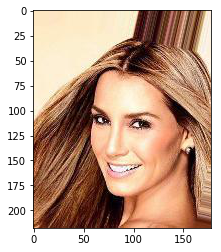

In [3]:
img = Image.open(os.path.join(IMAGE_ROOT, '000001.jpg'))
print(np.asarray(img, dtype=np.uint8).shape)
plt.imshow(img);

# 2.导入数据

In [4]:
class CelebaDataset(Dataset):
    """Custom Dataset for loading CelebA face images"""

    def __init__(self, csv_path, img_dir, transform=None):
    
        df = pd.read_csv(csv_path, index_col=0)
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df.index.values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        return img

    def __len__(self):
        return self.img_names.shape[0]

In [5]:
custom_transform = transforms.Compose([transforms.CenterCrop((178, 178)),
                                       transforms.Resize((128, 128)),
                                       #transforms.Grayscale(),                                       
                                       #transforms.Lambda(lambda x: x/255.),
                                       transforms.ToTensor()])

train_dataset = CelebaDataset(csv_path='../data/celeba-gender-train.csv',
                              img_dir=IMAGE_ROOT,
                              transform=custom_transform)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4)

# 3.模型

In [6]:
class AutoEncoder(nn.Module):
    def __init__(self, in_channels, dec_channels, latent_size):
        super(AutoEncoder, self).__init__()
        
        self.in_channels = in_channels
        self.dec_channels = dec_channels
        self.latent_size = latent_size

        ###############
        # ENCODER
        ##############
        self.e_conv_1 = nn.Conv2d(in_channels, dec_channels, 
                                  kernel_size=(4, 4), stride=(2, 2), padding=1)
        self.e_bn_1 = nn.BatchNorm2d(dec_channels)

        self.e_conv_2 = nn.Conv2d(dec_channels, dec_channels*2, 
                                  kernel_size=(4, 4), stride=(2, 2), padding=1)
        self.e_bn_2 = nn.BatchNorm2d(dec_channels*2)

        self.e_conv_3 = nn.Conv2d(dec_channels*2, dec_channels*4, 
                                  kernel_size=(4, 4), stride=(2, 2), padding=1)
        self.e_bn_3 = nn.BatchNorm2d(dec_channels*4)

        self.e_conv_4 = nn.Conv2d(dec_channels*4, dec_channels*8, 
                                  kernel_size=(4, 4), stride=(2, 2), padding=1)
        self.e_bn_4 = nn.BatchNorm2d(dec_channels*8)

        self.e_conv_5 = nn.Conv2d(dec_channels*8, dec_channels*16, 
                                  kernel_size=(4, 4), stride=(2, 2), padding=1)
        self.e_bn_5 = nn.BatchNorm2d(dec_channels*16)
       
        self.e_fc_1 = nn.Linear(dec_channels*16*4*4, latent_size)

        ###############
        # DECODER
        ##############
        
        self.d_fc_1 = nn.Linear(latent_size, dec_channels*16*4*4)

        self.d_conv_1 = nn.Conv2d(dec_channels*16, dec_channels*8, 
                                  kernel_size=(4, 4), stride=(1, 1), padding=0)
        self.d_bn_1 = nn.BatchNorm2d(dec_channels*8)

        self.d_conv_2 = nn.Conv2d(dec_channels*8, dec_channels*4, 
                                  kernel_size=(4, 4), stride=(1, 1), padding=0)
        self.d_bn_2 = nn.BatchNorm2d(dec_channels*4)

        self.d_conv_3 = nn.Conv2d(dec_channels*4, dec_channels*2, 
                                  kernel_size=(4, 4), stride=(1, 1), padding=0)
        self.d_bn_3 = nn.BatchNorm2d(dec_channels*2)

        self.d_conv_4 = nn.Conv2d(dec_channels*2, dec_channels, 
                                  kernel_size=(4, 4), stride=(1, 1), padding=0)
        self.d_bn_4 = nn.BatchNorm2d(dec_channels)
        
        self.d_conv_5 = nn.Conv2d(dec_channels, in_channels, 
                                  kernel_size=(4, 4), stride=(1, 1), padding=0)
        
        
        # Reinitialize weights using He initialization
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.detach())
                m.bias.detach().zero_()
            elif isinstance(m, torch.nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight.detach())
                m.bias.detach().zero_()
            elif isinstance(m, torch.nn.Linear):
                nn.init.kaiming_normal_(m.weight.detach())
                m.bias.detach().zero_()


    def encode(self, x):
        
        #h1
        x = self.e_conv_1(x)
        x = F.leaky_relu(x, negative_slope=0.2, inplace=True)
        x = self.e_bn_1(x)
        
        #h2
        x = self.e_conv_2(x)
        x = F.leaky_relu(x, negative_slope=0.2, inplace=True)    
        x = self.e_bn_2(x)     

        #h3
        x = self.e_conv_3(x)
        x = F.leaky_relu(x, negative_slope=0.2, inplace=True) 
        x = self.e_bn_3(x)
        
        #h4
        x = self.e_conv_4(x)
        x = F.leaky_relu(x, negative_slope=0.2, inplace=True) 
        x = self.e_bn_4(x)
        
        #h5
        x = self.e_conv_5(x)
        x = F.leaky_relu(x, negative_slope=0.2, inplace=True) 
        x = self.e_bn_5(x)        
        
        #fc
        x = x.view(-1, self.dec_channels*16*4*4)
        x = self.e_fc_1(x)
        return x

    def decode(self, x):
        
        # h1
        #x = x.view(-1, self.latent_size, 1, 1)
        x = self.d_fc_1(x)
        
        x = F.leaky_relu(x, negative_slope=0.2, inplace=True)  
        x = x.view(-1, self.dec_channels*16, 4, 4) 

        
        # h2
        x = F.interpolate(x, scale_factor=2)
        x = F.pad(x, pad=(2, 1, 2, 1), mode='replicate')
        x = self.d_conv_1(x)
        x = F.leaky_relu(x, negative_slope=0.2, inplace=True)
        x = self.d_bn_1(x)
        
        # h3
        x = F.interpolate(x, scale_factor=2)
        x = F.pad(x, pad=(2, 1, 2, 1), mode='replicate')
        x = self.d_conv_2(x)
        x = F.leaky_relu(x, negative_slope=0.2, inplace=True)
        x = self.d_bn_2(x)
        
        # h4
        x = F.interpolate(x, scale_factor=2)
        x = F.pad(x, pad=(2, 1, 2, 1), mode='replicate')
        x = self.d_conv_3(x)
        x = F.leaky_relu(x, negative_slope=0.2, inplace=True)
        x = self.d_bn_3(x)  

        # h5
        x = F.interpolate(x, scale_factor=2)
        x = F.pad(x, pad=(2, 1, 2, 1), mode='replicate')
        x = self.d_conv_4(x)
        x = F.leaky_relu(x, negative_slope=0.2, inplace=True)
        x = self.d_bn_4(x)
        
        
        # out
        x = F.interpolate(x, scale_factor=2)
        x = F.pad(x, pad=(2, 1, 2, 1), mode='replicate')
        x = self.d_conv_5(x)
        x = torch.sigmoid(x)
        
        return x

    def forward(self, x):
        z = self.encode(x)
        decoded = self.decode(z)
        return z, decoded

# 4.训练

In [7]:
epoch_start = 1


torch.manual_seed(random_seed)
model = AutoEncoder(in_channels=3, dec_channels=32, latent_size=1000)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


################## Load previous
# the code saves the autoencoder
# after each epoch so that in case
# the training process gets interrupted,
# we will not have to start training it
# from scratch
files = os.listdir()

for f in files:
    if f.startswith('autoencoder_i_') and f.endswith('.pt'):
        print('Load', f)
        epoch_start = int(f.split('_')[-2]) + 1
        model.load_state_dict(torch.load(f))
        break
##################

start_time = time.time()
for epoch in range(epoch_start, num_epochs+1):
    
    
    for batch_idx, features in enumerate(train_loader):

        # don't need labels, only the images (features)
        features = features.to(device)
        
        ### FORWARD AND BACK PROP
        latent_vector, decoded = model(features)
        cost = F.mse_loss(decoded, features)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch, num_epochs, batch_idx, 
                     len(train_loader), cost))

    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
        
    # Save model
    if os.path.isfile('autoencoder_i_%d_%s.pt' % (epoch-1, device)):
        os.remove('autoencoder_i_%d_%s.pt' % (epoch-1, device))
    torch.save(model.state_dict(), 'autoencoder_i_%d_%s.pt' % (epoch, device))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/020 | Batch 0000/1272 | Cost: 0.1234
Epoch: 001/020 | Batch 0500/1272 | Cost: 0.0116
Epoch: 001/020 | Batch 1000/1272 | Cost: 0.0091
Time elapsed: 4.23 min
Epoch: 002/020 | Batch 0000/1272 | Cost: 0.0085
Epoch: 002/020 | Batch 0500/1272 | Cost: 0.0071
Epoch: 002/020 | Batch 1000/1272 | Cost: 0.0064
Time elapsed: 8.63 min
Epoch: 003/020 | Batch 0000/1272 | Cost: 0.0068
Epoch: 003/020 | Batch 0500/1272 | Cost: 0.0059
Epoch: 003/020 | Batch 1000/1272 | Cost: 0.0055
Time elapsed: 12.99 min
Epoch: 004/020 | Batch 0000/1272 | Cost: 0.0064
Epoch: 004/020 | Batch 0500/1272 | Cost: 0.0057
Epoch: 004/020 | Batch 1000/1272 | Cost: 0.0050
Time elapsed: 17.33 min
Epoch: 005/020 | Batch 0000/1272 | Cost: 0.0051
Epoch: 005/020 | Batch 0500/1272 | Cost: 0.0045
Epoch: 005/020 | Batch 1000/1272 | Cost: 0.0044
Time elapsed: 21.67 min
Epoch: 006/020 | Batch 0000/1272 | Cost: 0.0047
Epoch: 006/020 | Batch 0500/1272 | Cost: 0.0045
Epoch: 006/020 | Batch 1000/1272 | Cost: 0.0043
Time elapsed: 26.0

# 5.评估

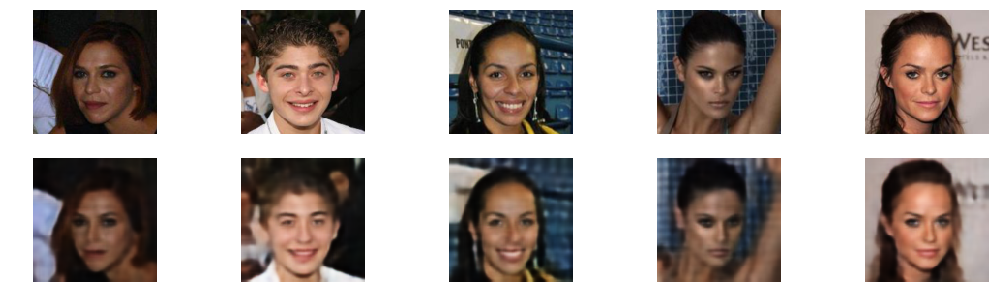

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt


model = AutoEncoder(in_channels=3, dec_channels=32, latent_size=1000)
model = model.to(device)
model.load_state_dict(torch.load('autoencoder_i_20_%s.pt' % device))
model.eval()
torch.manual_seed(random_seed)

for batch_idx, features in enumerate(train_loader):
    features = features.to(device)
    logits, decoded = model(features)
    break



##########################
### VISUALIZATION
##########################

n_images = 5

fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(18, 5))
orig_images = features.detach().cpu().numpy()[:n_images]
orig_images = np.moveaxis(orig_images, 1, -1)

decoded_images = decoded.detach().cpu().numpy()[:n_images]
decoded_images = np.moveaxis(decoded_images, 1, -1)


for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        ax[i].axis('off')
        ax[i].imshow(img[i])